The shape of dataset =  (9568, 5) 

data types : 
 AT    float64
V     float64
AP    float64
RH    float64
PE    float64
dtype: object
number of duplicate rows (before):  41
number of duplicate rows (after):  0


 Temperature               0
Exhaust Vacuum            0
Ambient Pressure          0
Relative Humidity         0
Elec_Energy_Production    0
dtype: int64
New shape =  (9527, 5)


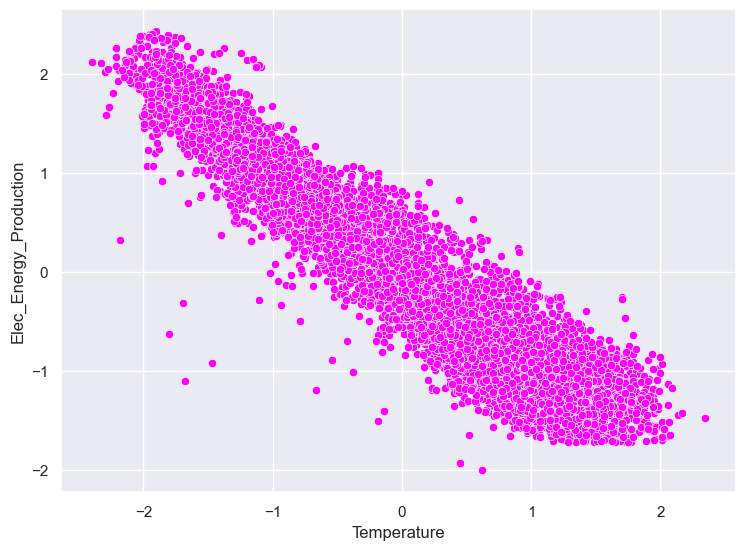

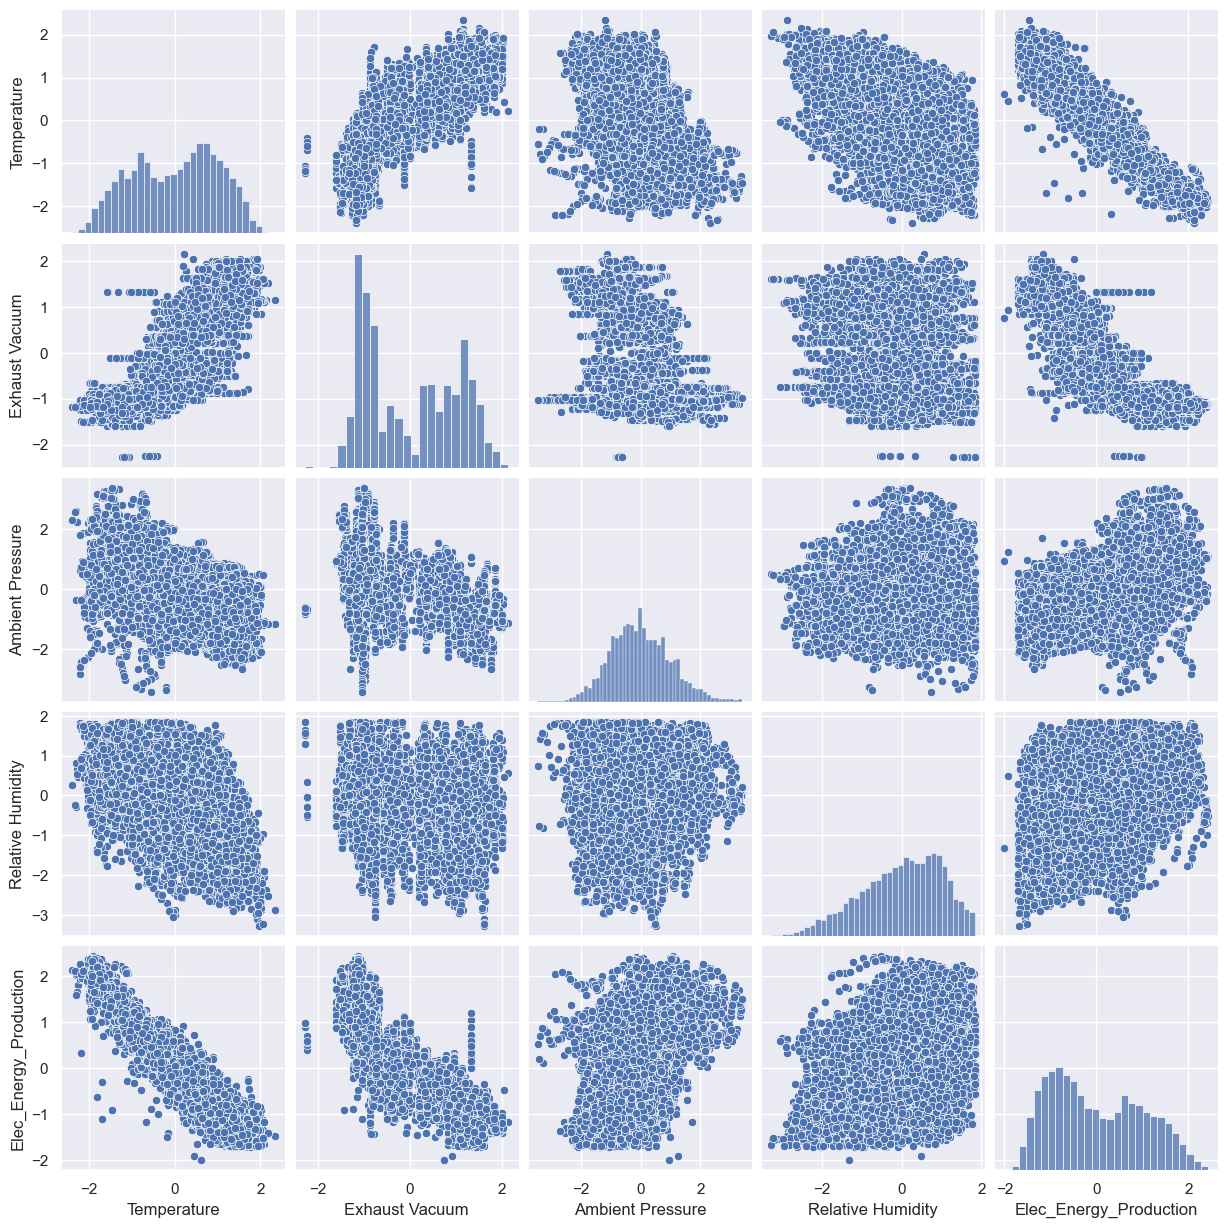

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics


#loading dataframe
d = pd.read_csv("Energie_Regression.csv")

#Checking and exploring dataframe
print("The shape of dataset = ",d.shape,"\n")
print("data types : \n",d.dtypes) #dispaly the type of each column 
d.head() #display the first 5 instances

#Renaming the columns
d = d.rename(columns={"AT": "Temperature", "V": "Exhaust Vacuum","AP":"Ambient Pressure", "RH": "Relative Humidity", "PE": "Elec_Energy_Production"})
d.head()

#Dropping duplicated rows
duplicate_rows = d[d.duplicated()]
print("number of duplicate rows (before): ", duplicate_rows.shape[0]) 
d = d.drop_duplicates()
print("number of duplicate rows (after): ", d[d.duplicated()].shape[0])

#Checking for missing or null values
print("\n\n",d.isnull().sum()) # I found zero missing values so no need to drop them

#Display new dataframe's shape
print("New shape = ",d.shape)


#Feature scaling = Standardization
scaler = StandardScaler()

d_scaled = pd.DataFrame(scaler.fit_transform(d), columns=['Temperature','Exhaust Vacuum','Ambient Pressure','Relative Humidity','Elec_Energy_Production'])
d_scaled.head() 

# Data visualization (to see the data distribution then decide wether to apply polynomial regression or linear)
sns.set(style='darkgrid', rc={'figure.figsize':(8.7,6.27)}) 
sns.scatterplot(x="Temperature",y="Elec_Energy_Production",data=d_scaled, color="magenta")
sns.pairplot(d_scaled)





theta =  [ 1.97094066e-05 -8.67712651e-01 -1.74626148e-01  2.07312233e-02
 -1.40637929e-01]
Le coefficient de détermination R2(training) =  0.9280268864587659
Le coefficient de détermination ajusté R2_adjusted(training) =  0.9279836788264433
Cost function (validating)=  0.03655295645682177
Le coefficient de détermination R2(validating) =  0.9251634024992258
Le coefficient de détermination ajusté R2_adjusted (validating)=  0.9249531873377068

       Real_Val  Predicted_Val
0       437.99     428.487977
1       479.61     483.050787
2       429.18     432.324494
3       465.23     464.880356
4       432.87     435.902528
...        ...            ...
1425    439.55     443.343282
1426    434.11     438.545109
1427    452.08     449.463414
1428    456.31     462.762616
1429    442.75     442.421465

[1430 rows x 2 columns]

 Le coefficient de détermination R2(testing) =  0.9330520900446754

 Le coefficient de détermination ajusté R2_adjusted (testing)=  0.932864166086906

 L'erreur absolu

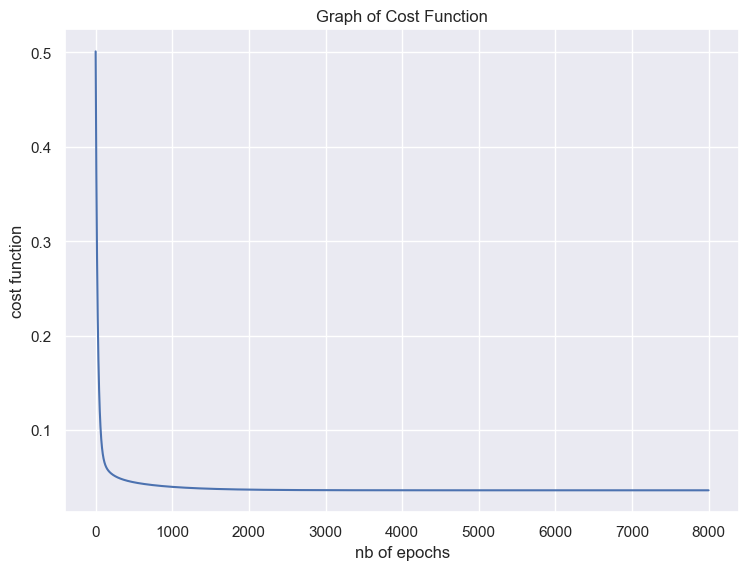

In [6]:
#Gradient descent
#Dataset(scaled) spliting : 70% train, 15% validate, 15% test
x_scaled = d_scaled.iloc[:, 0:4]  
y_scaled = d_scaled.iloc[:,4]

x_main, x_test, y_main, y_test = train_test_split(x_scaled , y_scaled , test_size=0.15 , random_state=8)
x_train, x_valid, y_train, y_valid = train_test_split(x_main, y_main, test_size=0.1764, random_state=8)


def model(theta, x) :
    return np.dot(x,theta)

def derivative(theta, x, y) :
    m = len(y)
    return (1/m) * x.T.dot(model(theta,x) - y)

def cost_func(x,y,theta) :
    m = x.shape[0] #nb of training samples
    return (1/(2*m)) * np.sum((model(theta, x)-y)**2)
    
def gradient_descent(learning_rate,x,y,nb_epochs) :
    x_zero = np.ones([x.shape[0],1])
    x.insert(0,"x_zero",x_zero)
    theta = np.zeros((x.shape[1])) #initialization of theta
    cost_values = []
    for i in range(nb_epochs) :
        j_theta = cost_func(x,y,theta)  
        cost_values.append(j_theta)
        theta = theta - learning_rate * derivative(theta,x,y) #mise à jour des valeurs de theta
    return theta, cost_values

def adjusted_R_2(R_2,m,p) :
    a = (1-R_2)*(m-1)
    b = m - p - 1
    return 1 - a/b 

R_2_Values =[]


#1-Training phase
#Training the regression model with gradient descent
nb_epochs = 8000  
learning_rate = 0.008

theta_final, list_of_costs = gradient_descent(learning_rate, x_train, y_train, nb_epochs)
print("theta = ",theta_final.values)

#Evaluating regression model
loss_graph = sns.lineplot(list_of_costs)
loss_graph.set(xlabel ="nb of epochs", ylabel = "cost function",title="Graph of Cost Function")

y_train_pred = model(theta_final, x_train)

R_2 = metrics.r2_score(y_train,y_train_pred)
print("Le coefficient de détermination R2(training) = ",R_2)

print("Le coefficient de détermination ajusté R2_adjusted(training) = ",adjusted_R_2(R_2,x_train.shape[0],x_train.shape[1]-1))

if R_2 not in R_2_Values :
    R_2_Values.append(R_2)
    
#2-Validating phase
x_zero = np.ones([x_valid.shape[0],1])
x_valid.insert(0,"x_zero",x_zero)

print("Cost function (validating)= ",cost_func(x_valid,y_valid,theta_final) )

y_valid_pred = model(theta_final, x_valid)

R_2 = metrics.r2_score(y_valid,y_valid_pred)
print("Le coefficient de détermination R2(validating) = ",R_2)
print("Le coefficient de détermination ajusté R2_adjusted (validating)= ",adjusted_R_2(R_2,x_valid.shape[0],x_valid.shape[1]-1))

if R_2 not in R_2_Values :
    R_2_Values.append(R_2)

#3-Testing phase
x_zero = np.ones([x_test.shape[0],1])
x_test.insert(0,"x_zero",x_zero)

y_test_pred = model(theta_final, x_test)

scaler_y = StandardScaler()
#the scaler "scaler_y" fitting "y"(the target from the dataset not scaled 'd')
scaler_y.fit_transform(np.array(d.iloc[:,4]).reshape(-1, 1))
#reversing feature scaling for 'y_test_pred' and 'y_test' (pour les afficher sous le format initial)
y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1))
y_test = scaler_y.inverse_transform(y_test.values.reshape(-1, 1))


df = pd.DataFrame({'Real_Val': y_test.flatten(), 'Predicted_Val': y_test_pred.flatten()})
print("\n",df)

R_2 = metrics.r2_score(y_test,y_test_pred)
print("\n Le coefficient de détermination R2(testing) = ",R_2)
print("\n Le coefficient de détermination ajusté R2_adjusted (testing)= ",adjusted_R_2(R_2,x_test.shape[0],x_test.shape[1]-1))
#MAE: It is defined as the sum of all the residuals(the difference between the actual and pedicted value) divided by
#the total number of examples in dataset, so it represents the absolute average distance of our model prediction
print("\n L'erreur absolue moyenne MAE = ",metrics.mean_absolute_error(y_test,y_test_pred))#this is a low MAE value so the model is correctly predicting

if R_2 not in R_2_Values :
    R_2_Values.append(R_2)


theta :  [ 4.58283670e+02 -1.98768755e+00 -2.33836041e-01  5.90907556e-02
 -1.64317384e-01]
Le coefficient de détermination R2(training) =  0.9280269724250338
Le coefficient de détermination ajusté R2_adjusted(training) =  0.9279837648443194
Cost function (validating)=  10.61224761060366
Le coefficient de détermination R2(validating) =  0.92515682853796
Le coefficient de détermination ajusté R2_adjusted(validating) =  0.9249465949102577

       Real_Val  Predicted_Val
0       437.99     428.485433
1       479.61     483.054361
2       429.18     432.322276
3       465.23     464.873743
4       432.87     435.901518
...        ...            ...
1425    439.55     443.338098
1426    434.11     438.548359
1427    452.08     449.462774
1428    456.31     462.765143
1429    442.75     442.418562

[1430 rows x 2 columns]

 Le coefficient de détermination R2(testing) =  0.933049555240454

 Le coefficient de détermination ajusté R2_adjusted (testing)=  0.9328616241674447

 L'erreur absolue mo

<Axes: xlabel='Technique', ylabel='R2_score'>

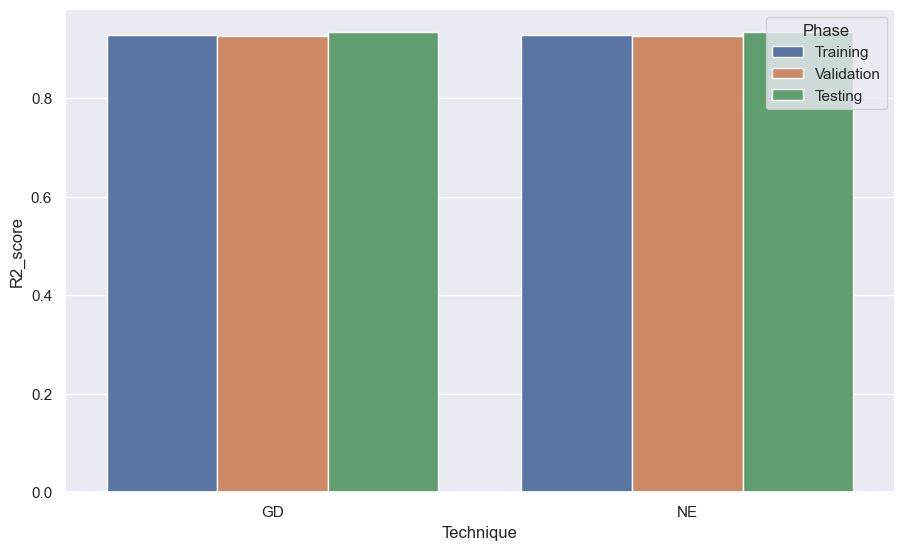

In [7]:
# Normal Equation
#Dataset spliting : 70% train, 15% validate, 15% test
x = d.iloc[:, 0:4]  
y = d.iloc[:,4]

x_main, x_test, y_main, y_test = train_test_split(x , y , test_size=0.15 , random_state=8)
x_train, x_valid, y_train, y_valid = train_test_split(x_main, y_main, test_size=0.1764, random_state=8)


def Normal_Equation(x , y) :
    x_zero = np.ones([x.shape[0],1])
    x.insert(0,"x_zero",x_zero)
    thetas = np.dot(np.linalg.inv(np.dot(x.T, x)), np.dot(x.T, y))
    return thetas

#1-Trainig phase
thetas_final = Normal_Equation(x_train, y_train)
print("theta : ",thetas_final)

y_train_pred = model(thetas_final, x_train)
R_2 = metrics.r2_score(y_train,y_train_pred)
print("Le coefficient de détermination R2(training) = ",R_2)
print("Le coefficient de détermination ajusté R2_adjusted(training) = ",adjusted_R_2(R_2,x_train.shape[0],x_train.shape[1]-1))

if R_2 not in R_2_Values :
    R_2_Values.append(R_2)

#2-Validating phase
x_zero = np.ones([x_valid.shape[0],1])
x_valid.insert(0,"x_zero",x_zero)
print("Cost function (validating)= ",cost_func(x_valid,y_valid,thetas_final) )

y_valid_pred = model(thetas_final, x_valid)
R_2 = metrics.r2_score(y_valid,y_valid_pred)
print("Le coefficient de détermination R2(validating) = ",R_2)
print("Le coefficient de détermination ajusté R2_adjusted(validating) = ",adjusted_R_2(R_2,x_valid.shape[0],x_valid.shape[1]-1))

if R_2 not in R_2_Values :
    R_2_Values.append(R_2)

#3-Testing phase
x_zero = np.ones([x_test.shape[0],1])
x_test.insert(0,"x_zero",x_zero)

y_test_pred = model(thetas_final, x_test)

df = pd.DataFrame({'Real_Val': y_test.values.flatten(), 'Predicted_Val': y_test_pred.flatten()})
print("\n",df)

R_2 = metrics.r2_score(y_test,y_test_pred)
print("\n Le coefficient de détermination R2(testing) = ",R_2)
print("\n Le coefficient de détermination ajusté R2_adjusted (testing)= ",adjusted_R_2(R_2,x_test.shape[0],x_test.shape[1]-1))
#MAE: It is defined as the sum of all the residuals(the difference between the actual and pedicted value) divided by
#the total number of examples in dataset, so it represents the absolute average distance of our model prediction
print("\n L'erreur absolue moyenne MAE = ",metrics.mean_absolute_error(y_test,y_test_pred))#this is a low MAE value so the model is correctly predicting

if R_2 not in R_2_Values :
    R_2_Values.append(R_2)

#Comparison between Gradient descent and Normal equation
data = {'Phase': ['Training', 'Validation', 'Testing', 'Training', 'Validation', 'Testing'],
        'R2_score': R_2_Values,
        'Technique' : ['GD','GD','GD', 'NE', 'NE', 'NE']  } 

# Create DataFrame
df = pd.DataFrame(data)
sns.set(style='darkgrid', rc={'figure.figsize':(10.7,6.27)})
sns.barplot(data=df , x='Technique' , y='R2_score' , hue='Phase')
